In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.096 s)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    plt.style.use("~/matplotlib.mplstyle")
except: raise

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return pd.DataFrame()
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [7]:
plt.rcParams['font.family'] = 'cursive'
plt.rcParams['axes.labelsize'] = 'medium'

## Pairwise Plots

In [8]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree) -> float:
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

In [15]:
def plot_pairwise(prop1, prop2, ax = None, saveas = None, same_doi = True):
    rows = postgres.raw_sql("""
        Select name, stdunit From property_metadata
        Where property = :prop;
    """, prop=prop1)
    p1 = rows[0].name
    u1 = rows[0].stdunit

    rows = postgres.raw_sql("""
        Select name, stdunit From property_metadata
        Where property = :prop;
    """, prop=prop2)
    p2 = rows[0].name
    u2 = rows[0].stdunit

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2.4, 2.5))
    else:
        fig = None

    # Group by only common materails or both materail and doi
    groupby = 'ed.material, ed.doi' if same_doi else 'ed.material'

    # Group by doi
    gpt = execute(f"""
        SELECT * FROM (
            SELECT {groupby},
                avg(CASE WHEN ed.property = :p1 THEN ed.value END) AS prop1,
                avg(CASE WHEN ed.property = :p2 THEN ed.value END) AS prop2
            FROM extracted_data ed 
            WHERE ed."method" = 'GPT-3.5'
            GROUP BY {groupby}
            ORDER BY ed.material
        ) AS ft
        WHERE ft.prop1 IS NOT NULL AND ft.prop2 IS NOT NULL;
    """, p1=prop1, p2=prop2)

    if gpt.shape[0]:
        ax.plot(gpt.prop1, gpt.prop2, '.', color="#e0809dcc", label = 'GPT-3.5')

    # Group by doi
    mbt = execute(f"""
        SELECT * FROM (
            SELECT {groupby},
                avg(CASE WHEN ed.property = :p1 THEN ed.value END) AS prop1,
                avg(CASE WHEN ed.property = :p2 THEN ed.value END) AS prop2
            FROM extracted_data ed 
            JOIN extracted_properties ep ON ep.id = ed.property_id 
            JOIN extracted_materials em ON em.id = ep.material_id
            WHERE ed."method" = 'MaterialsBERT'
            AND EXISTS (
                SELECT fp.para_id FROM filtered_paragraphs fp 
                WHERE fp.filter_name LIKE '%_ner_full'
                AND fp.para_id = em.para_id
            )
            GROUP BY {groupby}
            ORDER BY ed.material
        ) AS ft
        WHERE ft.prop1 IS NOT NULL AND ft.prop2 IS NOT NULL;
    """, p1=prop1, p2=prop2)
    if mbt.shape[0]:
        ax.plot(mbt.prop1, mbt.prop2, '.', color="#009d9acc", label = 'MaterialsBERT')

    if fig and (gpt.shape[0] or mbt.shape[0]):
        ax.legend(ncol=2, loc=(0.1, 1.02))
    
    if fig:
        ax.set(xlabel=f"{p1} ({u1})", ylabel=f"{p2} ({u2})")
    else:
        ax.set(title=f"{prop2} ({gpt.shape[0] + mbt.shape[0]:,})")

    if fig:
        if saveas:
            plt.savefig(saveas, dpi=600)
        plt.tight_layout()
        plt.show()

    return gpt, mbt

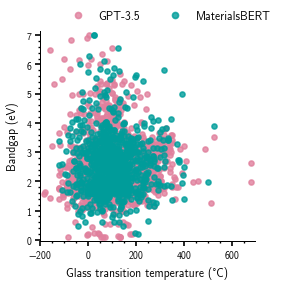

(     material   prop1     prop2
 0         (1)  103.50  2.980000
 1          10   68.10  2.302030
 2         10a  191.50  2.100000
 3         10b   76.50  2.100000
 4          11   73.55  2.207819
 ...       ...     ...       ...
 1872       Z0  289.50  3.270000
 1873       Z3  283.40  1.850000
 1874       Z4   56.20  1.550000
 1875   Z-PDPF  185.00  2.810000
 1876  γ-Al2O3 -102.00  6.200000
 
 [1877 rows x 3 columns],
        material       prop1     prop2
 0            +}  -33.050000  1.940000
 1           0.5   69.875000  3.000000
 2            15    5.182500  1.800000
 3           1-b  111.000000  2.475000
 4            4)  131.000000  1.900000
 ..          ...         ...       ...
 908         ZnO  105.218333  3.139828
 909  ZnO-Ag NCs   23.000000  3.285000
 910         ZnS   64.000000  3.403286
 911          Zr  -26.000000  0.806000
 912     ZrO_{2}  -42.000000  4.125833
 
 [913 rows x 3 columns])

In [16]:
plot_pairwise('tg', 'bandgap', same_doi=False)

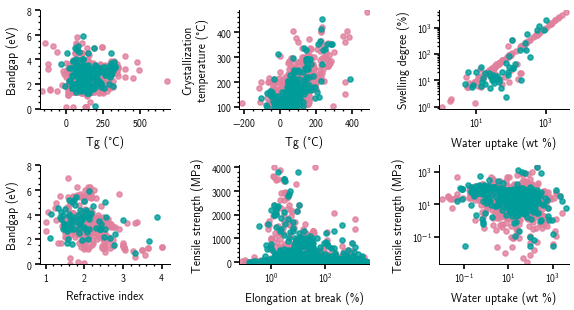

In [14]:
fig, axes = plt.subplots(2, 3, dpi=120, figsize = (4.9, 2.7))
axes = axes.flatten()

ax = axes[0]
gpt, mbt = plot_pairwise('tg', 'bandgap', ax = ax)
ax.set(xlabel='Tg (°C)', ylabel='Bandgap (eV)', title=None, ylim=(0, 6.1))

ax = axes[1]
gpt, mbt = plot_pairwise('tg', 'ct', ax = ax)
ax.set(xlabel='Tg (°C)', ylabel='Crystallization\ntemperature (°C)', title=None)

ax = axes[2]
plot_pairwise('wu', 'sd', ax = ax)
ax.set(xlabel='Water uptake (wt %)', ylabel='Swelling degree (%)', title=None)
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)

ax = axes[3]
plot_pairwise('ri', 'bandgap', ax = ax)
ax.set(xlabel='Refractive index', ylabel='Bandgap (eV)', title=None, xlim=(0.85, 4.2), ylim=(0, 8.0))

ax = axes[4]
plot_pairwise('eab', 'ts', ax = ax)
ax.set(xlabel='Elongation at break (%)', ylabel='Tensile strength (MPa)', title=None)
ax.set_xscale("log", base=10)

ax = axes[5]
plot_pairwise('wu', 'ts', ax = ax)
ax.set(xlabel='Water uptake (wt %)', ylabel='Tensile strength (MPa)', title=None)
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)

plt.tight_layout()

plt.savefig("notebooks/pair_selected_plots.png", dpi=600)
plt.show()

In [38]:
df = pd.concat([gpt, mbt]).sort_values('prop1')

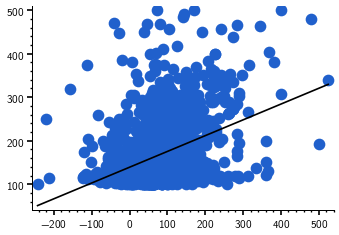

In [39]:
#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(df.prop1, df.prop2, 1))
model2 = np.poly1d(np.polyfit(df.prop1, df.prop2, 2))
model3 = np.poly1d(np.polyfit(df.prop1, df.prop2, 3))
model4 = np.poly1d(np.polyfit(df.prop1, df.prop2, 4))
model5 = np.poly1d(np.polyfit(df.prop1, df.prop2, 5))

#create scatterplot
polyline = np.linspace(min(df.prop1), max(df.prop1), 50)
plt.scatter(df.prop1, df.prop2)

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='k')
plt.show()